# Standard Hopfield Networks
References: 
* https://towardsdatascience.com/hopfield-networks-are-useless-heres-why-you-should-learn-them-f0930ebeadcd
* https://github.com/philipjk/genetic_algorithm_optimization_sklearn-based/blob/master/hopfield_networks.ipynb
* https://ml-jku.github.io/hopfield-layers/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Utility function to generate random patterns to put on test the pattern retrieval

In [5]:
def generate_paterns(n=1, x=64, y=64):
    res = []
    fig, ax = plt.subplots(1, n, figsize=(18, 6))
    try:
        axes = ax.ravel()
    except:
        axes = []
        axes.append(ax)
    for i in range(n):
        im = -np.ones((x, y))
        # Randomly select a box in the image
        im[np.random.randint(0, y / 2):np.random.randint(x/2, y),
           np.random.randint(0, y/2):np.random.randint(x/2, y)] = 1
        axes[i].imshow(im, cmap='binary')
        axes[i].set_title(f"pattern #{i}")
        im = np.reshape(im, (x * y))
        res.append(im)
    return np.array(res).T

### Define the Hopfield Energy Function
This is the hopfield energy that we expect to minimize. This is equivalent to:
$$
E = -\frac{1}{2}\sum_{i}\sum_{j}w_{ij}V_iV_j

= -\frac{1}{2}V^TWV
$$

However, in this excercise, when we call this function, we only pass one state, hence, there is not need to transpose the state.

In [7]:
def energy(state, W):
    """Hopfield Energy"""
    return -0.5 * state @ W @ state

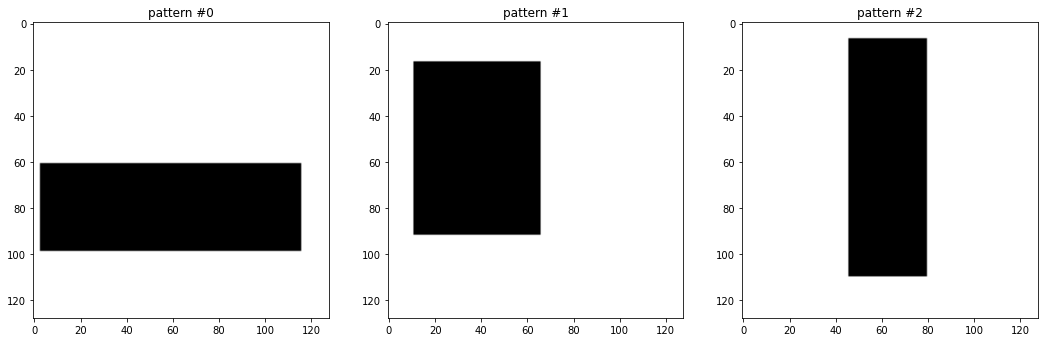

In [53]:
patterns = 3
width = 128
height = 128
X = generate_paterns(patterns, width, height)

### Build the weight matrix
Let $c$ be the "learning rate". In classic Hopfield Networks, the corresponding $W$ matrix is:
$$
W = \sum_{i}^N x_i x_i^T

= XX^T
$$

The $W$ matrix store patterns, which can be retrieved from a **state pattern** $\xi$, i.e., by multiplying $\xi$ by $W$ several times we could retrieve the original pattern.

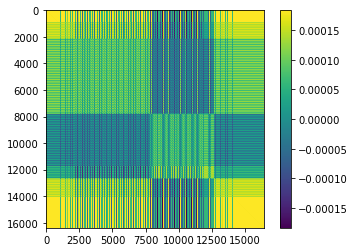

In [54]:
c = 1
W = c * (1 / (width * height)) * (X @ X.T)
# Zero diagional
np.fill_diagonal(W, 0)
plt.imshow(W)
plt.colorbar()
plt.show()

### Get a corrupted pattern
Select a random pattern from the examples and corrupt it with Gaussian noise.

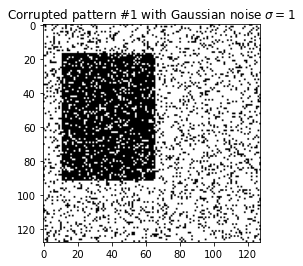

In [67]:
which = np.random.randint(0, patterns)
sigma = 1
vt = X[:, which] + sigma * np.random.randn((width * height))
vt[vt > 0] = 1
vt[vt < 0] = -1

plt.imshow(np.reshape(vt, (width, height)), cmap='binary')
plt.title(f"Corrupted pattern #{which} with Gaussian noise $\sigma={sigma}$")
plt.show()

## Reconstruct from corrupted pattern
The idea is to perform iteratively a matrix multiplication of the corrupted pattern with the Weight Matrix and calculate the energy generated by the result. We will repeat this process till we get no change from the energy of the new pattern or if we exhausted a predefined number of iterations.

### The Syncrhonous update rule
The sync update rule is to repeatedly multiply the state patter $\xi$ with the weight matrix $W$, substract the bias and take the sign:
$$
\xi^{t+1}=sgn(W\xi^t-b)
$$

For the example elaborated in this notebook, the bias term is dropped for simplicity, hence we can define the new state pattern as:
$$
\xi^{t+1}=sgn(W\xi^t)
$$

### The Asynchronous update rule
The async update rile performs this update only for one component of $\xi$ and then selects the next component for update. i.e., it updates one element of $\xi$ at the time while performing the same operation above. Convergence is reached if $\xi^{t+1} = \xi^t$. The asynchronous version of the update rule from above minimizes the energy function E:
$$
E = -\frac{1}{2}\xi^TW\xi+\xi^Tb
= -\frac{1}{2}\sum_{i=1}^{d}\sum_{j=1}^{d}w_{ij}\xi_i\xi_j+\sum_{i=1}^db_i\xi_i
$$

In [68]:
evolution = []
energy_history = []
energy_old = np.infty
energy_new = energy(vt, W)
steps = 200
iteration = 0
sync_update = False

while (energy_old > energy_new) and iteration < steps:
    iteration += 1
    energy_old = energy_new
    evolution.append(np.copy(vt))
    energy_history.append(energy_old)

    # synchronous update, i.e., full
    if sync_update:
        vt = np.sign(W @ vt)
    else:
    # asynchronous update
        for pixel in np.split(np.random.randint(0,len(vt),width*height), 8):
            vt[pixel] = np.sign(W[pixel,:] @ vt)
    
    energy_new = energy(vt, W)

print(f"Stopped at iteration {iteration}")

Stopped at iteration 8


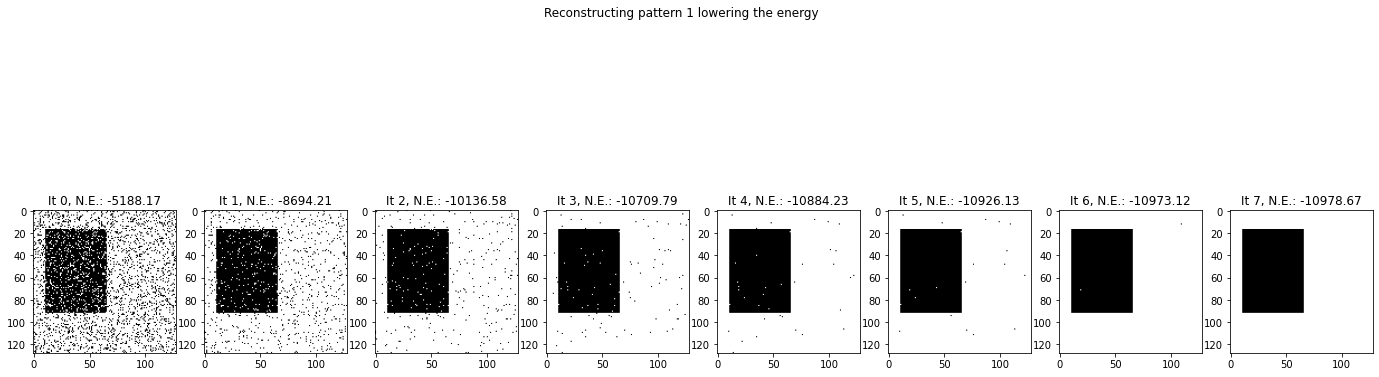

In [69]:
show_every = 1
fig, ax = plt.subplots(1, int(len(evolution) / show_every), figsize=(24, 8))
axes = ax.ravel()
fig.suptitle(f"Reconstructing pattern {which} lowering the energy")
plot_idx = 0
for idx in range(len(evolution)):
    if (idx % show_every) == 0:
        axes[plot_idx].imshow(np.reshape(evolution[idx], (width, height)), cmap='binary')
        axes[plot_idx].set_title(f"It {idx}, N.E.: {energy_history[idx]:.2f}")
        plot_idx += 1

plt.show()

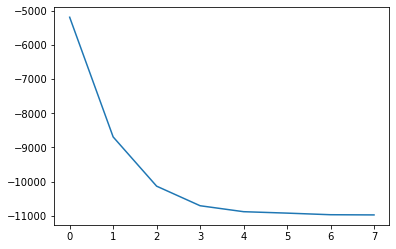

In [70]:
plt.plot(energy_history)
plt.show()

We can observe how the energy is reduced on each iteration and how the original pattern is retrieved.